In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import local_pkg_path
import counterfactual_evaluation as cfeval

matplotlib.rcParams['pdf.fonttype'] = 42

/home/mtian/anaconda3/envs/cfeval/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mtian/anaconda3/envs/cfeval/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mtian/anaconda3/envs/cfeval/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mtian/anaconda3/envs/cfeval/lib/python3.7/s

In [2]:
folds = ['Fold1', 'Fold2', 'Fold3']

num_queries = []

for fold in folds:
    sim_exp_train_vali_rankings = pd.read_csv(f'../build/simulation/{fold}/sim_exp_train_vali_rankings.csv')
    nqids = sim_exp_train_vali_rankings['qid'].nunique()
    num_queries.append(nqids)

Click models

In [3]:
examination_nf = 10
eta = 1
noise_eps = dict([(0, 0.1), (1, 1.0)])
noise_model = cfeval.simulator.ClickNoise(noise_eps)
examination_model = cfeval.simulator.ContextualPositionExamination(eta, examination_nf)
click_model = cfeval.simulator.PositionBasedClickModel(examination_model, noise_model)

In [4]:
weights_folds = []

In [5]:
for fold in folds:
    with open(f'../build/simulation/{fold}/examination_weights.pkl', 'rb') as f:
        weights = pickle.load(f)
    weights_folds.append(weights)

In [6]:
examination_model.weights

array([ 0.07374228,  0.55017753,  0.37465278, -0.28243492,  0.59273924,
        0.59856885, -0.78670589, -0.40368313, -0.32675595, -0.39030081])

In [7]:
examination_fc_folds = []

In [8]:
for fold in folds:
    with open(f'../build/simulation/{fold}/examination_fc_names.pkl', 'rb') as f:
        examination_fc = pickle.load(f)
    examination_fc_folds.append(examination_fc)

In [9]:
examination_fc_folds

[array(['13', '38', '53', '54', '63', '64', '88', '126', '129', '133'],
       dtype='<U3'),
 array(['13', '38', '63', '64', '95', '107', '108', '126', '129', '133'],
       dtype='<U3'),
 array(['13', '38', '53', '63', '64', '88', '107', '126', '129', '133'],
       dtype='<U3')]

In [10]:
def read_hte_outputs(fold, algo, total_num_queries):
    out = []
    for avg_clicks in [5, 10, 25, 50]:
        for nq in [total_num_queries // i for i in [100, 10, 2, 1]]:
            data = pd.read_csv(f'../build/simulation/{fold}/sim_exp_swap_{algo}_propensity_test_results_{avg_clicks}_{nq}.csv')
            data['rank'] = data.groupby(['qid', 'treatment_rank']).cumcount()
            data['avg_clicks'] = avg_clicks
            data['nqueries'] = nq
            data['fold'] = fold
            out.append(data)
    return pd.concat(out)

In [11]:
def compute_true_quantities(data, click_model, examination_fc):
    nrows = data.shape[0]
    # true click probability at 1
    data['true_click_prob@1'] = click_model.probabilities(
        np.ones(nrows), data['y'].values, data[examination_fc].values)
    data['exam_position'] = data['treatment_rank'] + 1
    # true click probability at k
    data['true_click_prob@k'] = click_model.probabilities(
        data['exam_position'].values, 
        data['y'].values, 
        data[examination_fc].values)
    # true examination probability at k
    data['true_exam_prob@k'] = click_model.examination.probabilities(
        data['exam_position'].values,
        data[examination_fc].values)
    # true examination probability at 1
    data['true_exam_prob@1'] = click_model.examination.probabilities(
        np.ones(nrows),
        data[examination_fc].values)
    # true tau
    data['true_tau'] = data['true_click_prob@1'] - data['true_click_prob@k']
    return data

Causal forests

In [12]:
causal_forests_estimations = []
for i, fold in enumerate(folds):
    tot_num_queries = num_queries[i]
    data = read_hte_outputs(fold, 'causal_forests', tot_num_queries)
    # get examination weights
    examination_weights = weights_folds[i]
    # set model weights to current weights
    click_model.examination.weights = examination_weights
    # get examination feature columns
    exam_fc = examination_fc_folds[i]
    data = compute_true_quantities(data, click_model, exam_fc)
    data = data.drop(exam_fc, axis=1)
    causal_forests_estimations.append(data)
    del data

In [13]:
causal_forests_estimations = pd.concat(causal_forests_estimations)

X-Learner

In [14]:
xlearner_estimations = []
for i, fold in enumerate(folds):
    tot_num_queries = num_queries[i]
    data = read_hte_outputs(fold, 'xlearner', tot_num_queries)
    data = data.rename(columns={'tau_pred': 'xlearner_tau_pred'})
    # get examination feature columns
    exam_fc = examination_fc_folds[i]
    data = data.drop(exam_fc, axis=1)
    xlearner_estimations.append(data)
    del data

In [15]:
xlearner_estimations = pd.concat(xlearner_estimations)

CPBM

In [16]:
cpbm_estimations = []
for i, fold in enumerate(folds):
    data= pd.read_csv(f'../build/simulation/{fold}/sim_exp_swap_cpbm_propensity_test_results.csv')
    data['fold'] = fold
    cpbm_estimations.append(data)

In [17]:
cpbm_estimations = pd.concat(cpbm_estimations)

Merge all together for plotting

In [18]:
merged_estimations = (causal_forests_estimations.merge(
    xlearner_estimations, how='left', on=['fold', 'qid', 'y', 'rank', 'treatment_rank', 'nqueries', 'avg_clicks'])
                      .merge(cpbm_estimations, how='left', on=['fold', 'qid', 'y', 'rank', 'exam_position', 'nqueries', 'avg_clicks']))

In [19]:
merged_estimations['xlearner_tau_pred'].isna().value_counts()

False    17405424
Name: xlearner_tau_pred, dtype: int64

In [20]:
merged_estimations['cpbm_tau'].isna().value_counts()

False    17405424
Name: cpbm_tau, dtype: int64

In [21]:
merged_estimations.head()

,treatment_rank,qid,y,tau_pred,rank,avg_clicks,nqueries,fold,true_click_prob@1,exam_position,true_click_prob@k,true_exam_prob@k,true_exam_prob@1,true_tau,xlearner_tau_pred,pair_1_k,pair_k_1,cpbm_tau
0,1,1,1,0.469480,0,5,158,Fold1,1.0,2,0.278962,0.278962,1.0,0.721038,0.527856,0.718110,0.122434,0.595676
1,1,1,1,0.407676,1,5,158,Fold1,1.0,2,1.000000,1.000000,1.0,0.000000,-0.235169,0.513077,0.546900,-0.033823
2,1,1,1,0.489190,2,5,158,Fold1,1.0,2,0.306476,0.306476,1.0,0.693524,0.706331,0.164202,0.003786,0.160416
3,1,1,0,0.379691,3,5,158,Fold1,0.1,2,0.100000,1.000000,1.0,0.000000,-0.292938,0.032913,0.017926,0.014987
4,1,1,0,0.446646,4,5,158,Fold1,0.1,2,0.077046,0.770457,1.0,0.022954,-0.320851,0.000147,0.000056,0.000091


Tau results

In [22]:
merged_estimations['Causal Forests'] = (merged_estimations['true_tau'] - merged_estimations['tau_pred']).pow(2)
merged_estimations['CPBM'] = (merged_estimations['true_tau'] - merged_estimations['cpbm_tau']).pow(2)
merged_estimations['X-Learner'] = (merged_estimations['true_tau'] - merged_estimations['xlearner_tau_pred']).pow(2)

In [23]:
merged_estimations['Causal Forests Error'] = merged_estimations['tau_pred'] - merged_estimations['true_tau']
merged_estimations['CPBM Error'] = merged_estimations['cpbm_tau'] - merged_estimations['true_tau']
merged_estimations['X-Learner Error'] = merged_estimations['xlearner_tau_pred'] - merged_estimations['true_tau']

In [24]:
merged_estimations.head()

,treatment_rank,qid,y,tau_pred,rank,avg_clicks,nqueries,fold,true_click_prob@1,exam_position,...,xlearner_tau_pred,pair_1_k,pair_k_1,cpbm_tau,Causal Forests,CPBM,X-Learner,Causal Forests Error,CPBM Error,X-Learner Error
0,1,1,1,0.469480,0,5,158,Fold1,1.0,2,...,0.527856,0.718110,0.122434,0.595676,0.063281,0.015715,0.037319,-0.251557,-0.125361,-0.193182
1,1,1,1,0.407676,1,5,158,Fold1,1.0,2,...,-0.235169,0.513077,0.546900,-0.033823,0.166199,0.001144,0.055305,0.407676,-0.033823,-0.235169
2,1,1,1,0.489190,2,5,158,Fold1,1.0,2,...,0.706331,0.164202,0.003786,0.160416,0.041752,0.284204,0.000164,-0.204334,-0.533108,0.012807
3,1,1,0,0.379691,3,5,158,Fold1,0.1,2,...,-0.292938,0.032913,0.017926,0.014987,0.144165,0.000225,0.085812,0.379691,0.014987,-0.292938
4,1,1,0,0.446646,4,5,158,Fold1,0.1,2,...,-0.320851,0.000147,0.000056,0.000091,0.179515,0.000523,0.118202,0.423692,-0.022864,-0.343806


In [25]:
merged_estimations[['X-Learner Error', 'X-Learner']].head()

,X-Learner Error,X-Learner
0,-0.193182,0.037319
1,-0.235169,0.055305
2,0.012807,0.000164
3,-0.292938,0.085812
4,-0.343806,0.118202


In [26]:
nqueries_to_percentange = dict()
for fold in folds:
    num_to_p = zip(sorted(merged_estimations[merged_estimations['fold']==fold]['nqueries'].unique()), ['1%', '10%', '50%', '100%'])
    nqueries_to_percentange.update(num_to_p)
nqueries_to_percentange

{158: '1%',
 1589: '10%',
 7948: '50%',
 15896: '100%',
 159: '1%',
 1596: '10%',
 7983: '50%',
 15966: '100%',
 1599: '10%',
 7996: '50%',
 15992: '100%'}

In [27]:
merged_estimations['Percentage of Training Queries'] = merged_estimations['nqueries'].map(nqueries_to_percentange.get)

In [28]:
merged_estimations['Percentage of Training Queries'] = pd.Categorical(merged_estimations['Percentage of Training Queries'], categories=['1%', '10%', '50%', '100%'])

In [29]:
merged_estimations = merged_estimations.rename(columns={'avg_clicks': 'Avg. Searches/Query'})

In [30]:
merged_estimations_positive = merged_estimations[merged_estimations['y'] == 1].copy()
merged_estimations_negative = merged_estimations[merged_estimations['y'] == 0].copy()

RMSE Table

In [31]:
tbl_rmse = (merged_estimations.groupby(['Avg. Searches/Query', 'Percentage of Training Queries'])[['CPBM', 'Causal Forests', 'X-Learner']].mean()
            .apply(np.sqrt))
tbl_rmse = tbl_rmse.stack().unstack(level=[0, 1])

In [32]:
tbl_rmse.round(3)

Avg. Searches/Query                5                           10         \
Percentage of Training Queries     1%    10%    50%   100%     1%    10%   
CPBM                            0.360  0.256  0.239  0.237  0.325  0.249   
Causal Forests                  0.335  0.276  0.255  0.249  0.317  0.270   
X-Learner                       0.374  0.315  0.275  0.260  0.350  0.302   

Avg. Searches/Query                              25                       \
Percentage of Training Queries    50%   100%     1%    10%    50%   100%   
CPBM                            0.239  0.238  0.304  0.246  0.238  0.237   
Causal Forests                  0.251  0.246  0.310  0.266  0.250  0.245   
X-Learner                       0.265  0.253  0.341  0.291  0.260  0.249   

Avg. Searches/Query                50                       
Percentage of Training Queries     1%    10%    50%   100%  
CPBM                            0.295  0.245  0.239  0.237  
Causal Forests                  0.307  0.265  0.249  0.244  
X-Learner                       0.341  0.286  0.256  0.247

Print latex table input

In [33]:
max_idx_along_col = np.argmin(tbl_rmse.round(3).values, axis=0)
for i, row in enumerate(tbl_rmse.round(3).values):
    str_row = []
    for j, col in enumerate(row):
        # if current number is the maximum, wray it with \textbf{}
        if max_idx_along_col[j] == i:
            v = f'\\textbf{{{col}}}'
        else:
            v = f'{col}'
        str_row.append(v)
    latex_row = ' & '.join(str_row)
    print('&', latex_row)

& 0.36 & \textbf{0.256} & \textbf{0.239} & \textbf{0.237} & 0.325 & \textbf{0.249} & \textbf{0.239} & \textbf{0.238} & \textbf{0.304} & \textbf{0.246} & \textbf{0.238} & \textbf{0.237} & \textbf{0.295} & \textbf{0.245} & \textbf{0.239} & \textbf{0.237}
& \textbf{0.335} & 0.276 & 0.255 & 0.249 & \textbf{0.317} & 0.27 & 0.251 & 0.246 & 0.31 & 0.266 & 0.25 & 0.245 & 0.307 & 0.265 & 0.249 & 0.244
& 0.374 & 0.315 & 0.275 & 0.26 & 0.35 & 0.302 & 0.265 & 0.253 & 0.341 & 0.291 & 0.26 & 0.249 & 0.341 & 0.286 & 0.256 & 0.247


RMSE Figure

In [34]:
merged_estimations = merged_estimations.rename(columns={'y': 'R'})

In [35]:
plot_results = (merged_estimations.groupby(['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'R'])[['CPBM', 'Causal Forests', 'X-Learner']].mean()
.apply(np.sqrt))

In [36]:
plot_results.head()

CPBM  \
fold  Avg. Searches/Query Percentage of Training Queries R             
Fold1 5                   1%                             0  0.324919   
                                                         1  0.425360   
                          10%                            0  0.253576   
                                                         1  0.275022   
                          50%                            0  0.250450   

                                                            Causal Forests  \
fold  Avg. Searches/Query Percentage of Training Queries R                   
Fold1 5                   1%                             0        0.331969   
                                                         1        0.387188   
                          10%                            0        0.254071   
                                                         1        0.309163   
                          50%                            0        0.243495   

                                                            X-Learner  
fold  Avg. Searches/Query Percentage of Training Queries R             
Fold1 5                   1%                             0   0.342642  
                                                         1   0.421905  
                          10%                            0   0.314042  
                                                         1   0.328800  
                          50%                            0   0.278887

In [37]:
plot_results = plot_results.reset_index()

plot_results_all = plot_results.copy()
plot_results_all['R'] = 'Any'
plot_results['R'] = plot_results['R'].astype(str)

plot_results_all = pd.concat([plot_results_all, plot_results])

In [38]:
plot_results_all.head()

,fold,Avg. Searches/Query,Percentage of Training Queries,R,CPBM,Causal Forests,X-Learner
0,Fold1,5,1%,Any,0.324919,0.331969,0.342642
1,Fold1,5,1%,Any,0.425360,0.387188,0.421905
2,Fold1,5,10%,Any,0.253576,0.254071,0.314042
3,Fold1,5,10%,Any,0.275022,0.309163,0.328800
4,Fold1,5,50%,Any,0.250450,0.243495,0.278887


In [39]:
plot_results_tall = plot_results.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'R'],
    value_vars=['Causal Forests', 'CPBM', 'X-Learner'],
    var_name='Estimation Method', value_name='RMSE')

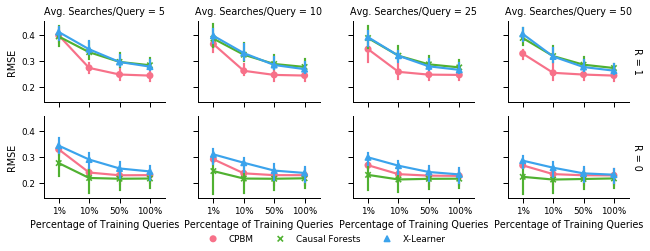

In [107]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                    data=plot_results_tall, order=['1%', '10%', '50%', '100%'], 
                    hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                    row_order=['1', '0'],
                    kind='point', palette='husl', height=1.75, aspect=1.4, margin_titles=True,
                    legend=False,
                    markers=['o', 'x', '^'])
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.2)

In [104]:
g.savefig('../build/simulation/figures/estimation-RMSE-relevance-separated-h1.75-a1.4.pdf')

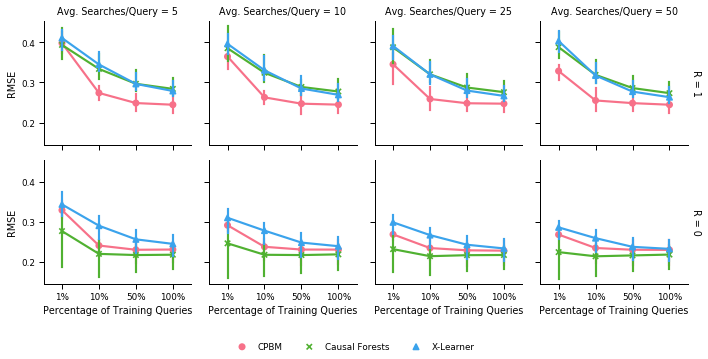

In [108]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                    data=plot_results_tall, order=['1%', '10%', '50%', '100%'], 
                    hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                    row_order=['1', '0'],
                    kind='point', palette='husl', height=2.5, aspect=1, margin_titles=True,
                    legend=False,
                    markers=['o', 'x', '^'])
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.2)

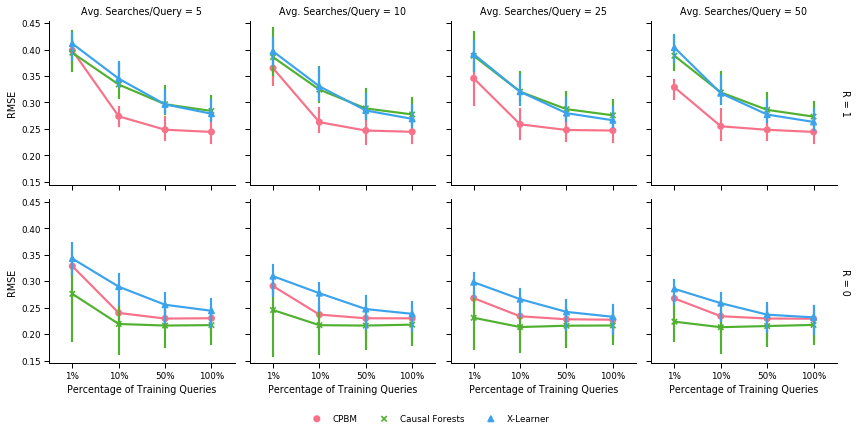

In [93]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                    data=plot_results_tall, order=['1%', '10%', '50%', '100%'], 
                    hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                    row_order=['1', '0'],
                    kind='point', palette='husl', height=3, aspect=1, margin_titles=True,
                    legend=False,
                    markers=['o', 'x', '^'])
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.15)

In [94]:
g.savefig('../build/simulation/figures/estimation-RMSE-relevance-separated.pdf')

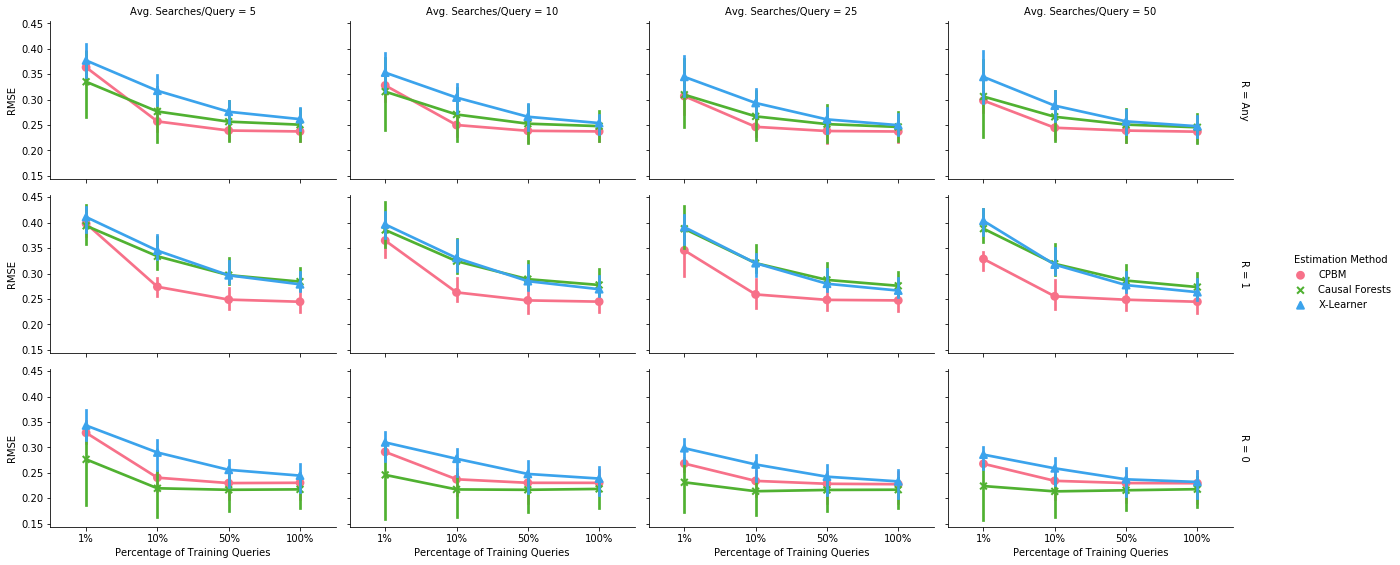

In [66]:
g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results_tall, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                row_order=['Any', '1', '0'],
                kind='point', palette='husl', height=2.5, aspect=1.5, margin_titles=True,
                markers=['o', 'x', '^'])

In [68]:
g.savefig('../build/simulation/figures/estimation-RMSE-relevance-separated.pdf')

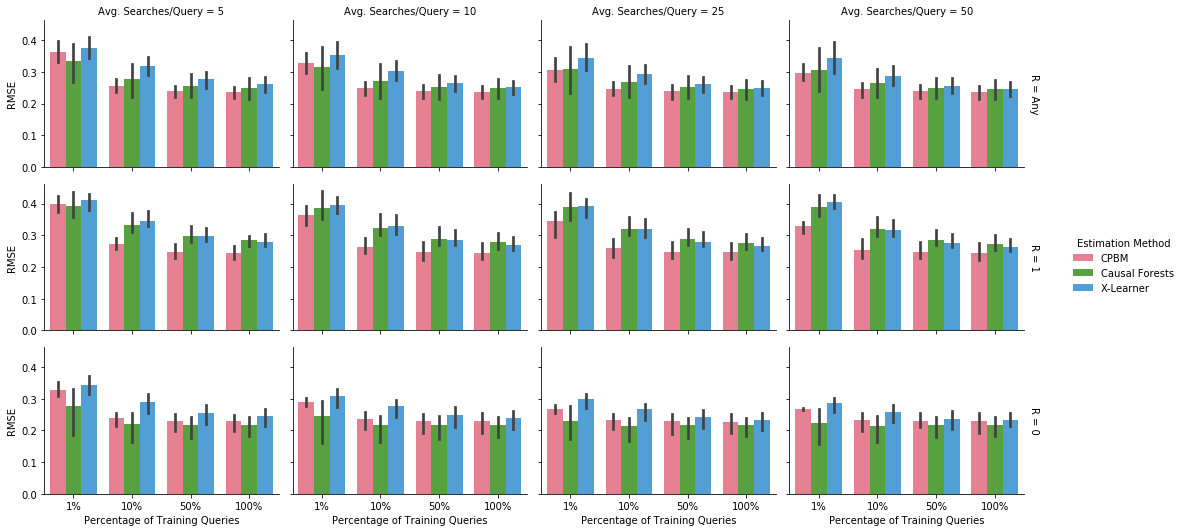

In [70]:
g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results_all, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                row_order=['Any', '1', '0'],
                kind='bar', palette='husl', height=2.5, aspect=1.5, margin_titles=True)

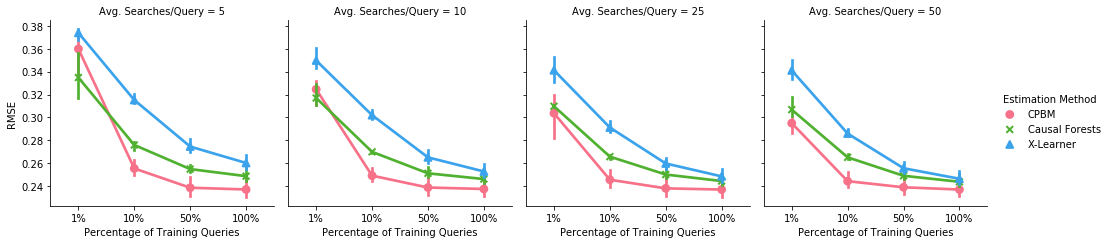

In [35]:
g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results, order=['1%', '10%', '50%', '100%'], hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                kind='point', palette='husl', height=3.5,
                markers=['o', 'x', '^'])

In [50]:
g.savefig('../build/simulation/figures/estimation-RMSE.pdf')

In [36]:
plot_results = (merged_estimations_positive.groupby(['fold', 'Avg. Searches/Query', 'Percentage of Training Queries'])[['CPBM', 'Causal Forests', 'X-Learner']].mean()
.apply(np.sqrt))

plot_results = plot_results.reset_index().melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries'],
    value_vars=['Causal Forests', 'CPBM', 'X-Learner'], 
    var_name='Estimation Method', value_name='RMSE')

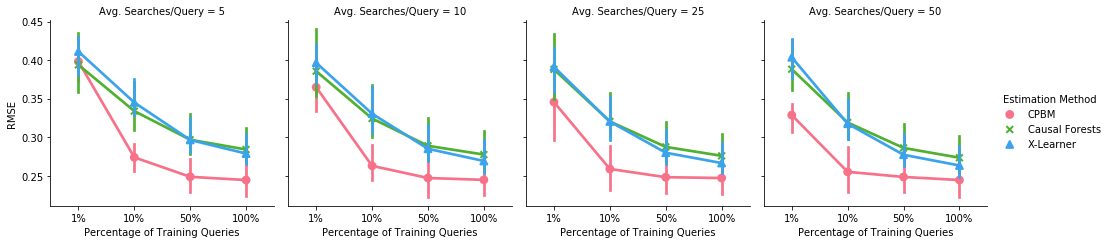

In [37]:
g = sns.catplot(x='Percentage of Training Queries', y='RMSE', hue='Estimation Method', 
                data=plot_results, order=['1%', '10%', '50%', '100%'], hue_order=['CPBM', 'Causal Forests', 'X-Learner'],
                col='Avg. Searches/Query', kind='point', palette='husl', height=3.5,
                markers=['o', 'x', '^'])

Error

In [92]:
merged_estimations.head()

,treatment_rank,qid,R,tau_pred,rank,Avg. Searches/Query,nqueries,fold,true_click_prob@1,exam_position,...,pair_1_k,pair_k_1,cpbm_tau,Causal Forests,CPBM,X-Learner,Causal Forests Error,CPBM Error,X-Learner Error,Percentage of Training Queries
0,1,1,1,0.469480,0,5,158,Fold1,1.0,2,...,0.718110,0.122434,0.595676,0.063281,0.015715,0.037319,-0.251557,-0.125361,-0.193182,1%
1,1,1,1,0.407676,1,5,158,Fold1,1.0,2,...,0.513077,0.546900,-0.033823,0.166199,0.001144,0.055305,0.407676,-0.033823,-0.235169,1%
2,1,1,1,0.489190,2,5,158,Fold1,1.0,2,...,0.164202,0.003786,0.160416,0.041752,0.284204,0.000164,-0.204334,-0.533108,0.012807,1%
3,1,1,0,0.379691,3,5,158,Fold1,0.1,2,...,0.032913,0.017926,0.014987,0.144165,0.000225,0.085812,0.379691,0.014987,-0.292938,1%
4,1,1,0,0.446646,4,5,158,Fold1,0.1,2,...,0.000147,0.000056,0.000091,0.179515,0.000523,0.118202,0.423692,-0.022864,-0.343806,1%


In [115]:
merged_estimations.shape

(17405424, 25)

In [109]:
plot_results = (merged_estimations.groupby(['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'R'])[['CPBM Error', 'Causal Forests Error', 'X-Learner Error']].mean())

In [110]:
plot_results = plot_results.reset_index()

In [118]:
plot_results = merged_estimations.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'R'],
    value_vars=['Causal Forests Error', 'CPBM Error', 'X-Learner Error'],
    var_name='Estimation Method', value_name='Error')

In [122]:
plot_results.head()

,fold,Avg. Searches/Query,Percentage of Training Queries,R,Estimation Method,Error
0,Fold1,5,1%,1,Causal Forests Error,-0.251557
1,Fold1,5,1%,1,Causal Forests Error,0.407676
2,Fold1,5,1%,1,Causal Forests Error,-0.204334
3,Fold1,5,1%,0,Causal Forests Error,0.379691
4,Fold1,5,1%,0,Causal Forests Error,0.423692


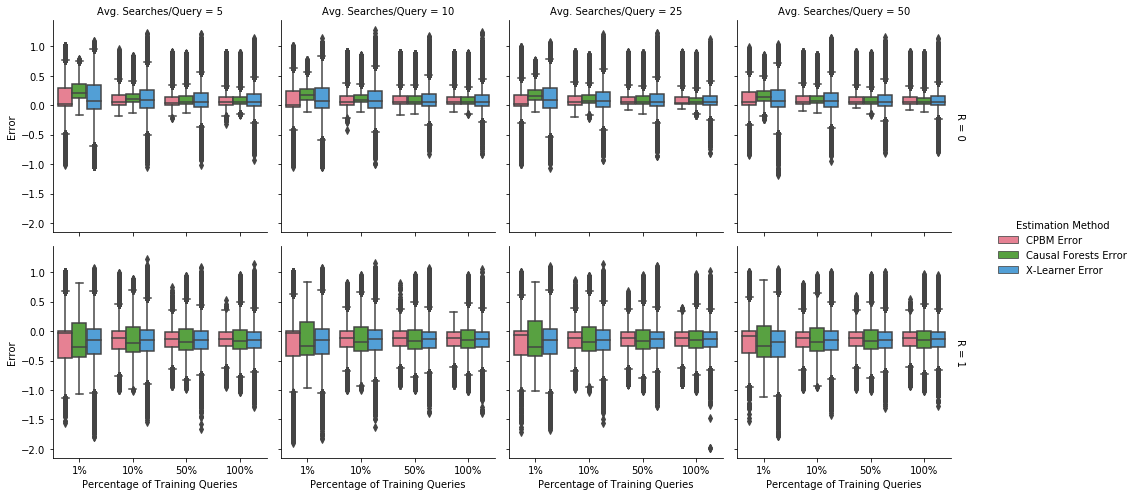

In [124]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                kind='box', palette='husl', height=3.5, margin_titles=True)

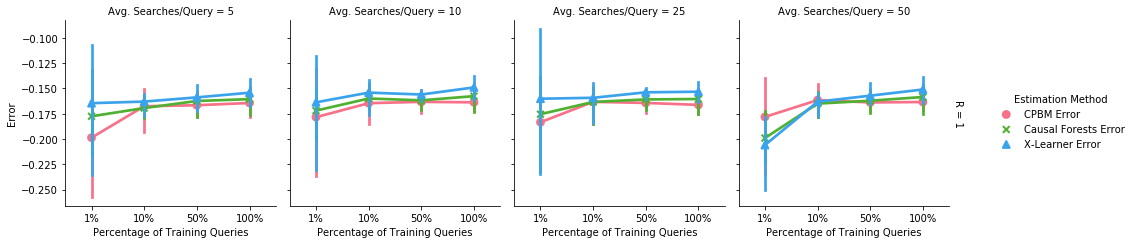

In [113]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results[plot_results['R']==1], order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                kind='hist', palette='husl', height=3.5, margin_titles=True,
                markers=['o', 'x', '^'])

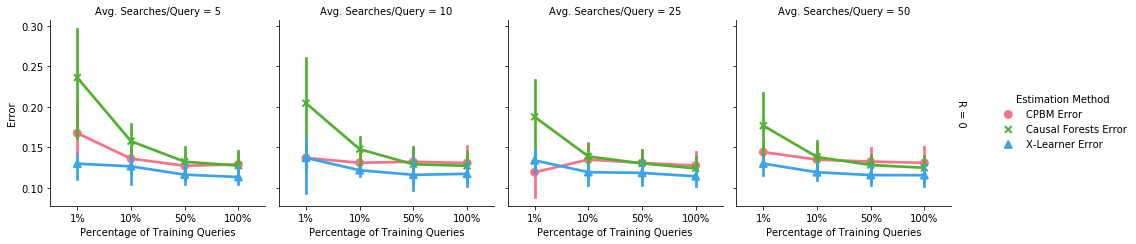

In [114]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results[plot_results['R']==0], order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                kind='point', palette='husl', height=3.5, margin_titles=True,
                markers=['o', 'x', '^'])

In [ ]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results_all, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                row_order=['Any', '1', '0'],
                kind='bar', palette='husl', height=2.5, aspect=1.5, margin_titles=True)

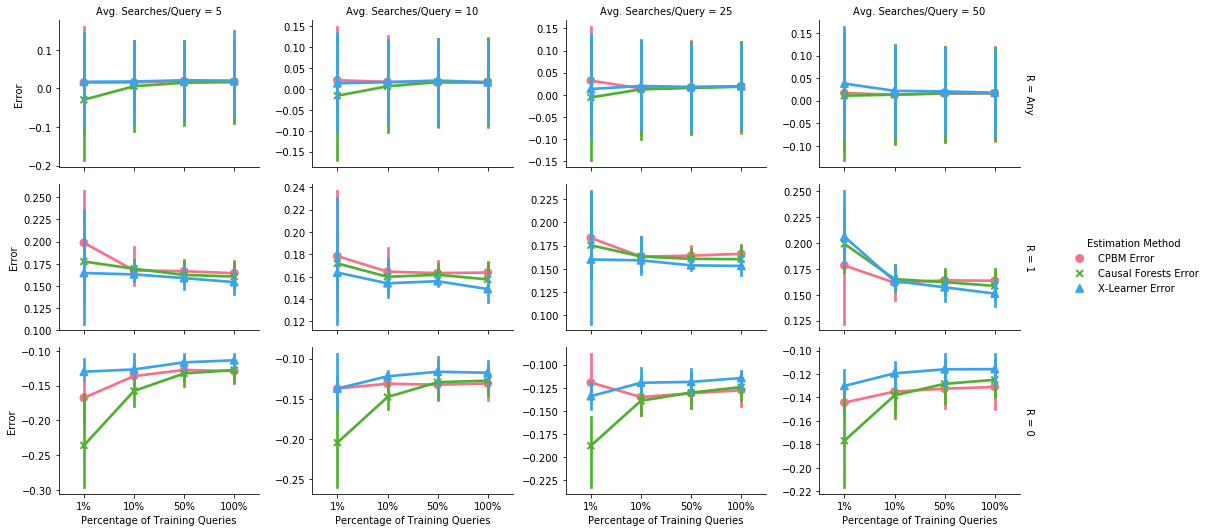

In [90]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results_all, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                row_order=['Any', '1', '0'], sharey=False,
                kind='point', palette='husl', height=2.5, aspect=1.5, margin_titles=True,
                markers=['o', 'x', '^'])

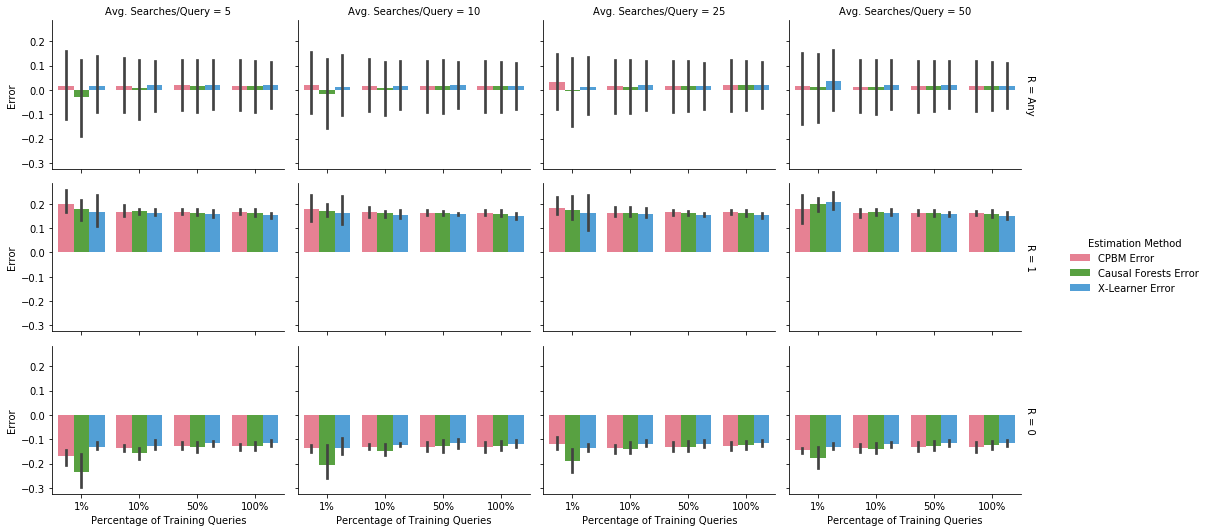

In [91]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results_all, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                row_order=['Any', '1', '0'],
                kind='bar', palette='husl', height=2.5, aspect=1.5, margin_titles=True)

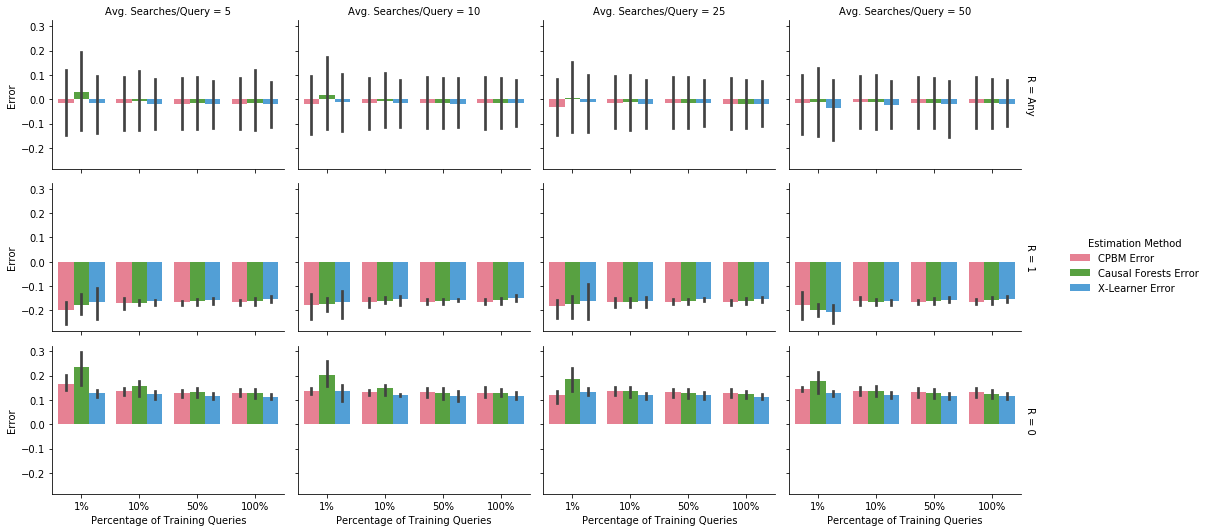

In [80]:
g = sns.catplot(x='Percentage of Training Queries', y='Error', hue='Estimation Method', row='R', col='Avg. Searches/Query',
                data=plot_results_all, order=['1%', '10%', '50%', '100%'], 
                hue_order=['CPBM Error', 'Causal Forests Error', 'X-Learner Error'],
                row_order=['Any', '1', '0'],
                kind='bar', palette='husl', height=2.5, aspect=1.5, margin_titles=True)

T test

Positive Examples

In [110]:
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. sample clicks {avg_clicks}; number of queries for estimation {nq}' + ''.join(['=']*20))
        baseline = merged_estimations_positive[(merged_estimations_positive['Avg. Searches/Query'] == avg_clicks) & (merged_estimations_positive['Percentage of Training Queries'] == nq)]['CPBM']
        causal_forests = merged_estimations_positive[(merged_estimations_positive['Avg. Searches/Query'] == avg_clicks) & (merged_estimations_positive['Percentage of Training Queries'] == nq)]['Causal Forests']
        baseline_metric = baseline.values
        causal_forests_metric = causal_forests.values
        print(f'baseline model tau_square_error: {round(baseline_metric.mean(), 4)}; causal forests model tau_square_error: {round(causal_forests_metric.mean(), 4)}')
        print('improvement', ((np.sqrt(causal_forests_metric.mean()) - np.sqrt(baseline_metric.mean())) / np.sqrt(baseline_metric.mean())) * 100, '%')
        t, p = stats.ttest_ind(baseline_metric, causal_forests_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. sample clicks 5; number of queries for estimation 1%====================
baseline model tau_square_error: 0.159; causal forests model tau_square_error: 0.1559
improvement -0.9796479404960537 %
t test result: t-statistic 7.1793127664804715, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 10%====================
baseline model tau_square_error: 0.0751; causal forests model tau_square_error: 0.1121
improvement 22.11341379416829 %
t test result: t-statistic -133.51446469616468, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 50%====================
baseline model tau_square_error: 0.062; causal forests model tau_square_error: 0.0885
improvement 19.414314234542925 %
t test result: t-statistic -105.45208790913169, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 100%====================
baseline model tau_square_error: 0.06; causal forests model tau_squ

In [112]:
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. sample clicks {avg_clicks}; number of queries for estimation {nq}' + ''.join(['=']*20))
        baseline = merged_estimations[(merged_estimations['Avg. Searches/Query'] == avg_clicks) & (merged_estimations['Percentage of Training Queries'] == nq)]['CPBM']
        causal_forests = merged_estimations[(merged_estimations['Avg. Searches/Query'] == avg_clicks) & (merged_estimations['Percentage of Training Queries'] == nq)]['Causal Forests']
        baseline_metric = baseline.values
        causal_forests_metric = causal_forests.values
        print(f'baseline model tau_square_error: {round(baseline_metric.mean(), 4)}; causal forests model tau_square_error: {round(causal_forests_metric.mean(), 4)}')
        print('improvement', ((np.sqrt(causal_forests_metric.mean()) - np.sqrt(baseline_metric.mean())) / np.sqrt(baseline_metric.mean())) * 100, '%')
        t, p = stats.ttest_ind(baseline_metric, causal_forests_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. sample clicks 5; number of queries for estimation 1%====================
baseline model tau_square_error: 0.1298; causal forests model tau_square_error: 0.1125
improvement -6.884836201514469 %
t test result: t-statistic 68.15478457772024, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 10%====================
baseline model tau_square_error: 0.0653; causal forests model tau_square_error: 0.0762
improvement 7.994555879390046 %
t test result: t-statistic -64.2921768443688, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 50%====================
baseline model tau_square_error: 0.057; causal forests model tau_square_error: 0.065
improvement 6.762510830899105 %
t test result: t-statistic -49.906756260367864, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 100%====================
baseline model tau_square_error: 0.0563; causal forests model tau_square

In [141]:
merged_estimations.head()

,treatment_rank,qid,y,tau_pred,rank,Avg. Searches/Query,nqueries,fold,true_click_prob@1,exam_position,...,pair_1_k,pair_k_1,cpbm_tau,Causal Forests,CPBM,X-Learner,Causal Forests Error,CPBM Error,X-Learner Error,Percentage of training queries
0,1,1,1,0.469480,0,5,158,Fold1,1.0,2,...,0.718110,0.122434,0.595676,0.063281,0.015715,0.037319,-0.251557,-0.125361,-0.193182,1%
1,1,1,1,0.407676,1,5,158,Fold1,1.0,2,...,0.513077,0.546900,-0.033823,0.166199,0.001144,0.055305,0.407676,-0.033823,-0.235169,1%
2,1,1,1,0.489190,2,5,158,Fold1,1.0,2,...,0.164202,0.003786,0.160416,0.041752,0.284204,0.000164,-0.204334,-0.533108,0.012807,1%
3,1,1,0,0.379691,3,5,158,Fold1,0.1,2,...,0.032913,0.017926,0.014987,0.144165,0.000225,0.085812,0.379691,0.014987,-0.292938,1%
4,1,1,0,0.446646,4,5,158,Fold1,0.1,2,...,0.000147,0.000056,0.000091,0.179515,0.000523,0.118202,0.423692,-0.022864,-0.343806,1%


In [113]:
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. sample clicks {avg_clicks}; number of queries for estimation {nq}' + ''.join(['=']*20))
        baseline = merged_estimations[(merged_estimations['Avg. Searches/Query'] == avg_clicks) & (merged_estimations['Percentage of Training Queries'] == nq)]['CPBM']
        causal_forests = merged_estimations[(merged_estimations['Avg. Searches/Query'] == avg_clicks) & (merged_estimations['Percentage of Training Queries'] == nq)]['X-Learner']
        baseline_metric = baseline.values
        causal_forests_metric = causal_forests.values
        print(f'baseline model tau_square_error: {round(baseline_metric.mean(), 4)}; X-Learner model tau_square_error: {round(causal_forests_metric.mean(), 4)}')
        print('improvement', ((np.sqrt(causal_forests_metric.mean()) - np.sqrt(baseline_metric.mean())) / np.sqrt(baseline_metric.mean())) * 100, '%')
        t, p = stats.ttest_ind(baseline_metric, causal_forests_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. sample clicks 5; number of queries for estimation 1%====================
baseline model tau_square_error: 0.1298; X-Learner model tau_square_error: 0.1399
improvement 3.8100482704053835 %
t test result: t-statistic -33.27772039368276, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 10%====================
baseline model tau_square_error: 0.0653; X-Learner model tau_square_error: 0.0994
improvement 23.356396357424877 %
t test result: t-statistic -171.78100872032562, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 50%====================
baseline model tau_square_error: 0.057; X-Learner model tau_square_error: 0.0755
improvement 15.014567206986651 %
t test result: t-statistic -107.24240987241981, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 100%====================
baseline model tau_square_error: 0.0563; X-Learner model tau_square_error: 0.0678

## Sweep results

In [24]:
i_fold = 0
fold = folds[i_fold]
nqids = num_queries[i_fold]

In [25]:
fold

'Fold1'

In [26]:
num_queries

[15896, 15966, 15992]

In [27]:
nqids = num_queries[i_fold]

In [10]:
model_dir = f'../build/simulation/{fold}/sweep'
algorithm_name = 'cf_binomial'
learning_rate = 0.1
regularizer = 'l2'
sweep_results = []
for avg_clicks in [5, 10, 25, 50]:
    for nq in [nqids // i for i in [100, 10, 2, 1]]:
        for batch_size in [32]:
            for reg_scale in [0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 30.0]:
                fpath = (Path(model_dir) / algorithm_name / f'avg_clicks_{avg_clicks}_nq_{nq}' / 
                         f'params_{learning_rate}_{batch_size}_{regularizer}_{reg_scale}' / 'sweep_results.csv')
                res = pd.read_csv(fpath)
                res['avg_clicks'] = avg_clicks
                res['nqueries'] = nq
                sweep_results.append(res)
sweep_results = pd.concat(sweep_results)

In [11]:
sweep_results['rank'] = sweep_results.groupby(['algorithm', 'avg_clicks', 'nqueries'])['metric/mrr'].rank(method='min', ascending=False)

In [12]:
sweep_results.groupby(['algorithm', 'avg_clicks', 'nqueries']).size()

algorithm    avg_clicks  nqueries
cf_binomial  5           159         10
                         1599        10
                         7996        10
                         15992       10
             10          159         10
                         1599        10
                         7996        10
                         15992       10
             25          159         10
                         1599        10
                         7996        10
                         15992       10
             50          159         10
                         1599        10
                         7996        10
                         15992       10
dtype: int64

In [13]:
sweep_results[sweep_results['rank'] == 1]

,algorithm,metric/mrr,epoch,batch_size,reg_scale,avg_clicks,nqueries,rank
0,cf_binomial,0.794173,6,32,5.00,5,159,1.0
0,cf_binomial,0.821387,6,32,20.00,5,1599,1.0
0,cf_binomial,0.841330,13,32,30.00,5,7996,1.0
0,cf_binomial,0.852424,6,32,20.00,5,15992,1.0
0,cf_binomial,0.818091,20,32,5.00,10,159,1.0
0,cf_binomial,0.834129,3,32,20.00,10,1599,1.0
0,cf_binomial,0.841586,3,32,0.10,10,7996,1.0
0,cf_binomial,0.848906,3,32,0.10,10,15992,1.0
0,cf_binomial,0.838819,15,32,0.05,25,159,1.0
0,cf_binomial,0.857119,25,32,5.00,25,1599,1.0


CPBM

In [14]:
model_dir = f'../build/simulation/{fold}/sweep'
algorithm_name = 'cpbm'
learning_rate = 0.1
regularizer = 'l2'
sweep_results = []
for avg_clicks in [5, 10, 25, 50]:
    for nq in [nqids // i for i in [100, 10, 2, 1]]:
        for batch_size in [32]:
            for reg_scale in [0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 30.0]:
                fpath = (Path(model_dir) / algorithm_name / f'avg_clicks_{avg_clicks}_nq_{nq}' / 
                         f'params_{learning_rate}_{batch_size}_{regularizer}_{reg_scale}' / 'sweep_results.csv')
                try:
                    res = pd.read_csv(fpath)
                except:
                    continue
                res['avg_clicks'] = avg_clicks
                res['nqueries'] = nq
                sweep_results.append(res)
sweep_results = pd.concat(sweep_results)

In [15]:
sweep_results['rank'] = sweep_results.groupby(['algorithm', 'avg_clicks', 'nqueries'])['metric/mrr'].rank(method='min', ascending=False)

In [16]:
sweep_results.groupby(['algorithm', 'avg_clicks', 'nqueries']).size()

algorithm  avg_clicks  nqueries
cpbm       5           159         10
                       1599        10
                       7996        10
                       15992       10
           10          159         10
                       1599        10
                       7996        10
                       15992       10
           25          159         10
                       1599        10
                       7996        10
                       15992       10
           50          159         10
                       1599        10
                       7996        10
                       15992       10
dtype: int64

In [17]:
sweep_results[sweep_results['rank'] == 1]

,algorithm,metric/mrr,epoch,batch_size,reg_scale,avg_clicks,nqueries,rank
0,cpbm,0.645050,6,32,0.05,5,159,1.0
0,cpbm,0.604523,6,32,0.10,5,1599,1.0
0,cpbm,0.685221,24,32,1.00,5,7996,1.0
0,cpbm,0.680770,18,32,0.10,5,15992,1.0
0,cpbm,0.713314,4,32,20.00,10,159,1.0
0,cpbm,0.624978,5,32,0.50,10,1599,1.0
0,cpbm,0.679644,22,32,0.05,10,7996,1.0
0,cpbm,0.692357,15,32,5.00,10,15992,1.0
0,cpbm,0.583245,23,32,0.01,25,159,1.0
0,cpbm,0.654683,16,32,0.01,25,1599,1.0


X Learner

In [33]:
[nqids // i for i in [100, 10, 2, 1]]

[158, 1589, 7948, 15896]

In [34]:
fold

'Fold1'

In [35]:
model_dir = f'../build/simulation/{fold}/sweep'
algorithm_name = 'xlearner'
learning_rate = 0.1
regularizer = 'l2'
sweep_results = []
for avg_clicks in [5, 10, 25, 50]:
    for nq in [nqids // i for i in [100, 10, 2, 1]]:
        for batch_size in [32]:
            for reg_scale in [0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 30.0]:
                fpath = (Path(model_dir) / algorithm_name / f'avg_clicks_{avg_clicks}_nq_{nq}' / 
                         f'params_{learning_rate}_{batch_size}_{regularizer}_{reg_scale}' / 'sweep_results.csv')
                res = pd.read_csv(fpath)
                res['avg_clicks'] = avg_clicks
                res['nqueries'] = nq
                sweep_results.append(res)
sweep_results = pd.concat(sweep_results)

In [36]:
sweep_results['rank'] = sweep_results.groupby(['algorithm', 'avg_clicks', 'nqueries'])['metric/mrr'].rank(method='min', ascending=False)

In [37]:
sweep_results.groupby(['algorithm', 'avg_clicks', 'nqueries']).size()

algorithm  avg_clicks  nqueries
xlearner   5           158         10
                       1589        10
                       7948        10
                       15896       10
           10          158         10
                       1589        10
                       7948        10
                       15896       10
           25          158         10
                       1589        10
                       7948        10
                       15896       10
           50          158         10
                       1589        10
                       7948        10
                       15896       10
dtype: int64

In [38]:
sweep_results[sweep_results['rank'] == 1]

,algorithm,metric/mrr,epoch,batch_size,reg_scale,avg_clicks,nqueries,rank
0,xlearner,0.830208,6,32,0.02,5,158,1.0
0,xlearner,0.846013,6,32,5.00,5,1589,1.0
0,xlearner,0.856713,6,32,20.00,5,7948,1.0
0,xlearner,0.849262,6,32,0.10,5,15896,1.0
0,xlearner,0.864032,31,32,0.50,10,158,1.0
0,xlearner,0.867136,4,32,1.00,10,1589,1.0
0,xlearner,0.858460,4,32,0.10,10,7948,1.0
0,xlearner,0.860108,3,32,30.00,10,15896,1.0
0,xlearner,0.853845,2,32,0.50,25,158,1.0
0,xlearner,0.866715,27,32,0.50,25,1589,1.0


## Test results

In [62]:
folds = ['Fold1', 'Fold2', 'Fold3']

num_queries = []

for fold in folds:
    sim_exp_train_vali_rankings = pd.read_csv(f'../build/simulation/{fold}/sim_exp_train_vali_rankings.csv')
    nqids = sim_exp_train_vali_rankings['qid'].nunique()
    num_queries.append(nqids)

In [63]:
num_queries

[15896, 15966, 15992]

In [64]:
algorithms = ['cpbm', 'cpbm_clipped_ips', 'cf_binomial', 'xlearner']

Read LTR test results

In [65]:
ltr_test_results = []
for algo in algorithms:
    for i, fold in enumerate(folds):
        model_dir = f'../build/simulation/{fold}/train_test/test_results'
        learning_rate = 0.1
        regularizer = 'l2'
        nqids = num_queries[i]
        for avg_clicks in [5, 10, 25, 50]:
            for nq in [nqids // i for i in [100, 10, 2, 1]]:               
                fpath = (Path(model_dir) / algo / f'avg_clicks_{avg_clicks}_nq_{nq}' / 
                         f'run_0' / f'{algo}.csv')
                res = pd.read_csv(fpath)
                res['avg_clicks'] = avg_clicks
                res['nqueries'] = nq
                res['fold'] = fold
                res['qd_id'] = np.arange(res.shape[0])
                ltr_test_results.append(res)
ltr_test_results = pd.concat(ltr_test_results)

In [66]:
ltr_test_results.head()

,reciprocal_rank,ndcg@1,ndcg@2,ndcg@3,ndcg@4,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@25,algo,avg_clicks,nqueries,fold,qd_id
0,0.5,0.0,0.386853,0.530721,0.732829,0.732829,0.732829,0.732829,0.732829,0.732829,cpbm,5,158,Fold1,0
1,1.0,1.0,0.613147,0.469279,0.390380,0.541400,0.789042,0.789042,0.789042,0.789042,cpbm,5,158,Fold1,1
2,0.5,0.0,0.386853,0.386853,0.386853,0.386853,0.571429,0.571429,0.571429,0.571429,cpbm,5,158,Fold1,2
3,0.1,0.0,0.000000,0.000000,0.000000,0.000000,0.289065,0.289065,0.289065,0.289065,cpbm,5,158,Fold1,3
4,0.2,0.0,0.000000,0.000000,0.000000,0.386853,0.386853,0.386853,0.386853,0.386853,cpbm,5,158,Fold1,4


In [67]:
num_tests = ltr_test_results.groupby(['fold', 'algo', 'avg_clicks', 'nqueries']).size().rename('count').reset_index()

In [68]:
num_tests[num_tests['fold'] == 'Fold1']['count'].unique()

array([4087])

In [69]:
num_tests[num_tests['fold'] == 'Fold2']['count'].unique()

array([4017])

In [70]:
num_tests[num_tests['fold'] == 'Fold3']['count'].unique()

array([3990])

In [71]:
nqueries_to_percentange = dict()
for fold in folds:
    num_to_p = zip(sorted(ltr_test_results[ltr_test_results['fold']==fold]['nqueries'].unique()), ['1%', '10%', '50%', '100%'])
    nqueries_to_percentange.update(num_to_p)
nqueries_to_percentange

{158: '1%',
 1589: '10%',
 7948: '50%',
 15896: '100%',
 159: '1%',
 1596: '10%',
 7983: '50%',
 15966: '100%',
 1599: '10%',
 7996: '50%',
 15992: '100%'}

In [72]:
ltr_test_results['Percentage of Training Queries'] = ltr_test_results['nqueries'].map(nqueries_to_percentange.get)
ltr_test_results = ltr_test_results.rename(columns={'avg_clicks': 'Avg. Searches/Query'})

In [73]:
ltr_test_results.head()

,reciprocal_rank,ndcg@1,ndcg@2,ndcg@3,ndcg@4,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@25,algo,Avg. Searches/Query,nqueries,fold,qd_id,Percentage of Training Queries
0,0.5,0.0,0.386853,0.530721,0.732829,0.732829,0.732829,0.732829,0.732829,0.732829,cpbm,5,158,Fold1,0,1%
1,1.0,1.0,0.613147,0.469279,0.390380,0.541400,0.789042,0.789042,0.789042,0.789042,cpbm,5,158,Fold1,1,1%
2,0.5,0.0,0.386853,0.386853,0.386853,0.386853,0.571429,0.571429,0.571429,0.571429,cpbm,5,158,Fold1,2,1%
3,0.1,0.0,0.000000,0.000000,0.000000,0.000000,0.289065,0.289065,0.289065,0.289065,cpbm,5,158,Fold1,3,1%
4,0.2,0.0,0.000000,0.000000,0.000000,0.386853,0.386853,0.386853,0.386853,0.386853,cpbm,5,158,Fold1,4,1%


In [74]:
ltr_test_results = ltr_test_results.rename(columns={'ndcg@10': 'nDCG@10'})

In [75]:
ltr_test_results['Percentage of Training Queries']

0         1%
1         1%
2         1%
3         1%
4         1%
        ... 
3985    100%
3986    100%
3987    100%
3988    100%
3989    100%
Name: Percentage of Training Queries, Length: 774016, dtype: object

In [76]:
ltr_test_results['Percentage of Training Queries'] = pd.Categorical(ltr_test_results['Percentage of Training Queries'].values, categories=['1%', '10%', '50%', '100%'])

In [77]:
ltr_test_results['Percentage of Training Queries']

0         1%
1         1%
2         1%
3         1%
4         1%
        ... 
3985    100%
3986    100%
3987    100%
3988    100%
3989    100%
Name: Percentage of Training Queries, Length: 774016, dtype: category
Categories (4, object): [1%, 10%, 50%, 100%]

nDCG10 Table

In [78]:
metric = 'nDCG@10'
metric_to_plot = ltr_test_results[['algo', 'Avg. Searches/Query', 'Percentage of Training Queries', 'qd_id', 'fold', metric]].copy()
rename_map = {'cf_binomial': 'Causal Forests LTR', 'cpbm': 'CPBM LTR', 'xlearner': 'X-Learner LTR', 'cpbm_clipped_ips': 'CPBM Clipped IPS LTR'}
metric_to_plot['algo'] = metric_to_plot['algo'].map(rename_map.get)
metric_to_plot = metric_to_plot.rename(columns={'algo': 'Algorithm'})

In [79]:
metric_to_plot.head()

,Algorithm,Avg. Searches/Query,Percentage of Training Queries,qd_id,fold,nDCG@10
0,CPBM LTR,5,1%,0,Fold1,0.732829
1,CPBM LTR,5,1%,1,Fold1,0.789042
2,CPBM LTR,5,1%,2,Fold1,0.571429
3,CPBM LTR,5,1%,3,Fold1,0.289065
4,CPBM LTR,5,1%,4,Fold1,0.386853


In [80]:
metric_mean = metric_to_plot.groupby(['Avg. Searches/Query', 'Percentage of Training Queries', 'Algorithm'])[metric].mean()

In [81]:
metric_mean.unstack(level=[0, 1]).round(3)

Avg. Searches/Query                5                           10         \
Percentage of Training Queries     1%    10%    50%   100%     1%    10%   
Algorithm                                                                  
CPBM Clipped IPS LTR            0.771  0.781  0.775  0.752  0.767  0.784   
CPBM LTR                        0.767  0.803  0.777  0.761  0.779  0.768   
Causal Forests LTR              0.817  0.814  0.811  0.814  0.817  0.809   
X-Learner LTR                   0.822  0.820  0.823  0.815  0.805  0.813   

Avg. Searches/Query                              25                       \
Percentage of Training Queries    50%   100%     1%    10%    50%   100%   
Algorithm                                                                  
CPBM Clipped IPS LTR            0.793  0.780  0.776  0.800  0.768  0.772   
CPBM LTR                        0.767  0.761  0.769  0.772  0.789  0.769   
Causal Forests LTR              0.812  0.816  0.827  0.820  0.821  0.835   
X-Learner LTR                   0.820  0.842  0.836  0.840  0.847  0.818   

Avg. Searches/Query                50                       
Percentage of Training Queries     1%    10%    50%   100%  
Algorithm                                                   
CPBM Clipped IPS LTR            0.828  0.794  0.818  0.785  
CPBM LTR                        0.795  0.813  0.819  0.820  
Causal Forests LTR              0.812  0.853  0.839  0.792  
X-Learner LTR                   0.843  0.835  0.828  0.865

Print rows for latex table

In [82]:
max_idx_along_col = np.argmax(metric_mean.unstack(level=[0, 1]).round(3).values, axis=0)
for i, row in enumerate(metric_mean.unstack(level=[0, 1]).round(2).values):
    str_row = []
    for j, col in enumerate(row):
        # if current number is the maximum, wray it with \textbf{}
        if max_idx_along_col[j] == i:
            v = f'\\textbf{{{col}}}'
        else:
            v = f'{col}'
        str_row.append(v)
    latex_row = ' & '.join(str_row)
    print('&', latex_row)

& 0.77 & 0.78 & 0.77 & 0.75 & 0.77 & 0.78 & 0.79 & 0.78 & 0.78 & 0.8 & 0.77 & 0.77 & 0.83 & 0.79 & 0.82 & 0.79
& 0.77 & 0.8 & 0.78 & 0.76 & 0.78 & 0.77 & 0.77 & 0.76 & 0.77 & 0.77 & 0.79 & 0.77 & 0.8 & 0.81 & 0.82 & 0.82
& 0.82 & 0.81 & 0.81 & 0.81 & \textbf{0.82} & 0.81 & 0.81 & 0.82 & 0.83 & 0.82 & 0.82 & \textbf{0.84} & 0.81 & \textbf{0.85} & \textbf{0.84} & 0.79
& \textbf{0.82} & \textbf{0.82} & \textbf{0.82} & \textbf{0.81} & 0.81 & \textbf{0.81} & \textbf{0.82} & \textbf{0.84} & \textbf{0.84} & \textbf{0.84} & \textbf{0.85} & 0.82 & \textbf{0.84} & 0.83 & 0.83 & \textbf{0.86}


In [83]:
from itertools import cycle

hatches = cycle(['//', '', '..', '\\\\'])

In [84]:
def add_hatches(x, y, **kwargs):
    ax = plt.gca()
    hs, l = ax.get_legend_handles_labels()
    for h in hs:
        hatch = next(hatches)
        h.set_hatch(hatch)
    for i, box in enumerate(ax.artists):
        hatch = next(hatches)
        box.set_hatch(hatch)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)

Boxplot

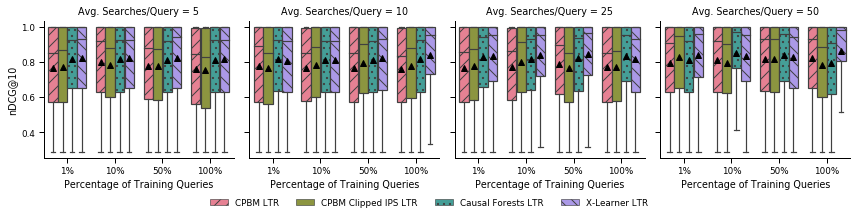

In [97]:
with sns.plotting_context('paper', 1):
    g = sns.catplot('Percentage of Training Queries', metric, 'Algorithm', data=metric_to_plot, col='Avg. Searches/Query', 
                    kind='box', palette='husl', hue_order=['CPBM LTR', 'CPBM Clipped IPS LTR', 'Causal Forests LTR', 'X-Learner LTR'],
                    showmeans=True, showfliers=False,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3, legend=False)
    g = g.map(add_hatches, 'Percentage of Training Queries', metric)
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.25)

In [98]:
g.savefig('../build/simulation/figures/result-ltr.pdf')

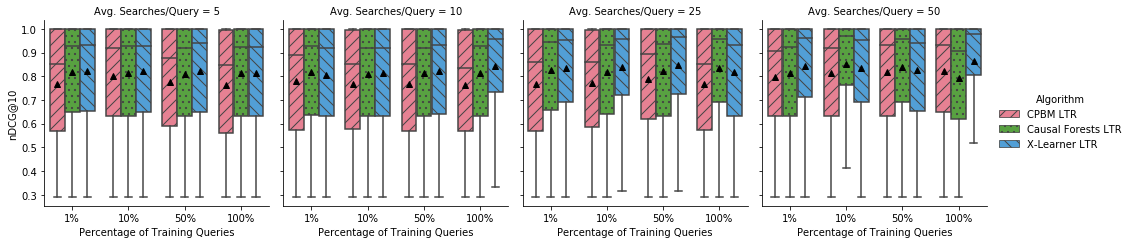

In [78]:
g = sns.catplot('Percentage of Training Queries', metric, 'Algorithm', data=metric_to_plot, col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['CPBM LTR', 'Causal Forests LTR', 'X-Learner LTR'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
g = g.map(add_hatches, 'Percentage of Training Queries', metric)
g.add_legend(title='Algorithm')

Boxplot columned by Percentage of Training Queries

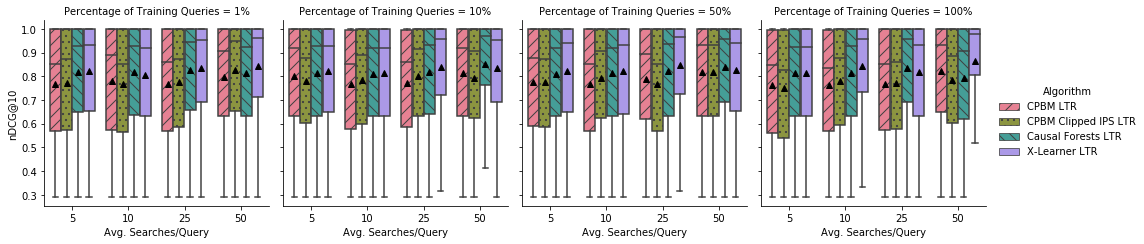

In [27]:
g = sns.catplot('Avg. Searches/Query', metric, 'Algorithm', data=metric_to_plot, col='Percentage of Training Queries', 
                kind='box', palette='husl', 
                hue_order=['CPBM LTR', 'CPBM Clipped IPS LTR', 'Causal Forests LTR', 'X-Learner LTR'], 
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
g = g.map(add_hatches, 'Avg. Searches/Query', metric)
g.add_legend(title='Algorithm')

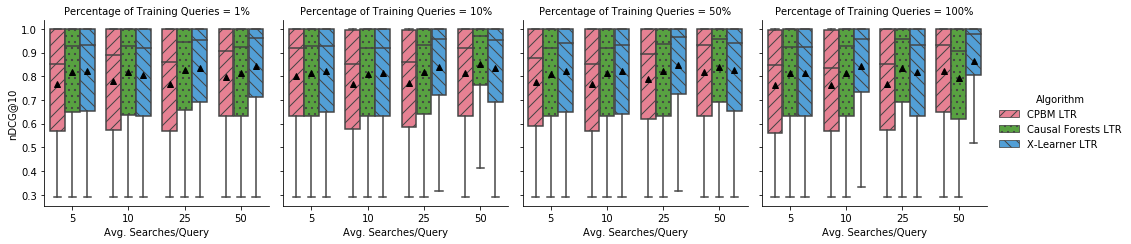

In [80]:
metric = 'nDCG@10'
metric_to_plot = ltr_test_results[['algo', 'Avg. Searches/Query', 'Percentage of Training Queries', 'qd_id', 'fold', metric]].copy()
rename_map = {'cf_binomial': 'Causal Forests LTR', 'cpbm': 'CPBM LTR', 'xlearner': 'X-Learner LTR'}
metric_to_plot['algo'] = metric_to_plot['algo'].map(rename_map.get)
metric_to_plot = metric_to_plot.rename(columns={'algo': 'Algorithm'})

g = sns.catplot('Avg. Searches/Query', metric, 'Algorithm', data=metric_to_plot, col='Percentage of Training Queries', 
                kind='box', palette='husl', hue_order=['CPBM LTR', 'Causal Forests LTR', 'X-Learner LTR'], 
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
g = g.map(add_hatches, 'Avg. Searches/Query', metric)
g.add_legend(title='Algorithm')

In [32]:
metric_to_plot.head()

,Algorithm,Avg. Searches/Query,Percentage of Training Queries,qd_id,fold,nDCG@10
0,CPBM LTR,5,1%,0,Fold1,0.732829
1,CPBM LTR,5,1%,1,Fold1,0.789042
2,CPBM LTR,5,1%,2,Fold1,0.571429
3,CPBM LTR,5,1%,3,Fold1,0.289065
4,CPBM LTR,5,1%,4,Fold1,0.386853


Kruskal Test

In [31]:
metric

'nDCG@10'

In [33]:
algo_metric = [metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                              (metric_to_plot['Percentage of Training Queries'] == nq) & 
                              (metric_to_plot['Algorithm'] == algo)][metric].values for algo in algo_pair]

In [34]:
algo_metric[0]

array([], dtype=float64)

In [36]:
algo_pair = ['CPBM LTR', 'CPBM Clipped IPS LTR', 'Causal Forests LTR', 'X-Learner LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo_metric = [metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                                      (metric_to_plot['Percentage of Training Queries'] == nq) & 
                                      (metric_to_plot['Algorithm'] == algo)][metric].values for algo in algo_pair]
        idx = np.argmax([am.mean() for am in algo_metric])
        print(f'the best algorithm {algo_pair[idx]}')
        t, p = stats.kruskal(*algo_metric)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
the best algorithm X-Learner LTR
t test result: t-statistic 578.7389426133051, p-value 0.0
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
the best algorithm X-Learner LTR
t test result: t-statistic 258.79096679501697, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
the best algorithm X-Learner LTR
t test result: t-statistic 476.1092813583609, p-value 0.0
====================avg. searches / query 5;  100% of training queries used for bias estimations====================
the best algorithm X-Learner LTR
t test result: t-statistic 784.3176544947445, p-value 0.0
====================avg. searches / query 10;  1% of training queries used for bias estimations====================
the best algorithm Causal Forests LTR
t test result: t-

T Test

CPBM vs Clipped IPS CPBM

In [152]:
algo_pair = ['CPBM LTR', 'CPBM Clipped IPS LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.7673; CPBM Clipped IPS LTR nDCG@10: 0.7715
CPBM Clipped IPS LTR improvement over CPBM LTR 0.5389972313785085 %
t test result: t-statistic -1.3556466305851895, p-value 0.1752
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.8026; CPBM Clipped IPS LTR nDCG@10: 0.7806
CPBM Clipped IPS LTR improvement over CPBM LTR -2.7462655522794193 %
t test result: t-statistic 7.390820362978889, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.7767; CPBM Clipped IPS LTR nDCG@10: 0.7746
CPBM Clipped IPS LTR improvement over CPBM LTR -0.2688983078927416 %
t test result: t-statistic 0.68983312083187, p-value 0.4903
====================avg. searches / query 5;  100% of training queries used f

In [154]:
algo_pair = ['CPBM LTR', 'Causal Forests LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.7673; Causal Forests LTR nDCG@10: 0.8168
Causal Forests LTR improvement over CPBM LTR 6.43970861271302 %
t test result: t-statistic -16.62369996761859, p-value 0.0
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.8026; Causal Forests LTR nDCG@10: 0.8145
Causal Forests LTR improvement over CPBM LTR 1.4783517903379038 %
t test result: t-statistic -4.056807529352762, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.7767; Causal Forests LTR nDCG@10: 0.811
Causal Forests LTR improvement over CPBM LTR 4.42029282946928 %
t test result: t-statistic -11.604080811609046, p-value 0.0
====================avg. searches / query 5;  100% of training queries used for bias estimations===

In [155]:
algo_pair = ['CPBM LTR', 'X-Learner LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.7673; X-Learner LTR nDCG@10: 0.8222
X-Learner LTR improvement over CPBM LTR 7.143221892460636 %
t test result: t-statistic -18.597336009278262, p-value 0.0
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.8026; X-Learner LTR nDCG@10: 0.8201
X-Learner LTR improvement over CPBM LTR 2.1713903398441157 %
t test result: t-statistic -6.012848317064603, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
CPBM LTR nDCG@10: 0.7767; X-Learner LTR nDCG@10: 0.8229
X-Learner LTR improvement over CPBM LTR 5.956206549070033 %
t test result: t-statistic -15.721709745646162, p-value 0.0
====================avg. searches / query 5;  100% of training queries used for bias estimations====================
CPBM LTR

In [139]:
algo_pair = ['X-Learner LTR', 'Causal Forests LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
X-Learner LTR nDCG@10: 0.8222; Causal Forests LTR nDCG@10: 0.8168
Causal Forests LTR improvement over X-Learner LTR -0.6566101591136854 %
t test result: t-statistic 1.882443494181324, p-value 0.0598
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
X-Learner LTR nDCG@10: 0.8201; Causal Forests LTR nDCG@10: 0.8145
Causal Forests LTR improvement over X-Learner LTR -0.6783097961190664 %
t test result: t-statistic 1.9420804897892954, p-value 0.0521
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
X-Learner LTR nDCG@10: 0.8229; Causal Forests LTR nDCG@10: 0.811
Causal Forests LTR improvement over X-Learner LTR -1.4495740925657306 %
t test result: t-statistic 4.155229423004672, p-value 0.0
====================avg. searches / query 5;  100% of train

In [157]:
algo_pair = ['CPBM Clipped IPS LTR', 'Causal Forests LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
CPBM Clipped IPS LTR nDCG@10: 0.7715; Causal Forests LTR nDCG@10: 0.8168
Causal Forests LTR improvement over CPBM Clipped IPS LTR 5.869077217624052 %
t test result: t-statistic -15.224503704441917, p-value 0.0
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
CPBM Clipped IPS LTR nDCG@10: 0.7806; Causal Forests LTR nDCG@10: 0.8145
Causal Forests LTR improvement over CPBM Clipped IPS LTR 4.343912721303567 %
t test result: t-statistic -11.497809100954687, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
CPBM Clipped IPS LTR nDCG@10: 0.7746; Causal Forests LTR nDCG@10: 0.811
Causal Forests LTR improvement over CPBM Clipped IPS LTR 4.701834290208313 %
t test result: t-statistic -12.312478737698477, p-value 0.0
====================avg.

In [156]:
algo_pair = ['CPBM Clipped IPS LTR', 'X-Learner LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of Training Queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
CPBM Clipped IPS LTR nDCG@10: 0.7715; X-Learner LTR nDCG@10: 0.8222
X-Learner LTR improvement over CPBM Clipped IPS LTR 6.568818909028197 %
t test result: t-statistic -17.18509397821627, p-value 0.0
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
CPBM Clipped IPS LTR nDCG@10: 0.7806; X-Learner LTR nDCG@10: 0.8201
X-Learner LTR improvement over CPBM Clipped IPS LTR 5.056521397404081 %
t test result: t-statistic -13.503821091919306, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
CPBM Clipped IPS LTR nDCG@10: 0.7746; X-Learner LTR nDCG@10: 0.8229
X-Learner LTR improvement over CPBM Clipped IPS LTR 6.241889191378934 %
t test result: t-statistic -16.434841278327248, p-value 0.0
====================avg. searches / query 5;  100% of 

In [151]:
algo_pair = ['CPBM ', 'X-Learner LTR']
for avg_clicks in [5, 10, 25, 50]:
    for nq in ['1%', '10%', '50%', '100%']:
        print(''.join(['=']*20) + f'avg. searches / query {avg_clicks};  {nq} of training queries used for bias estimations' + ''.join(['=']*20))
        algo1 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of training queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[0])]
        algo2 = metric_to_plot[(metric_to_plot['Avg. Searches/Query'] == avg_clicks) & 
                               (metric_to_plot['Percentage of training queries'] == nq) & 
                               (metric_to_plot['Algorithm'] == algo_pair[1])]        
        algo1_metric = algo1[metric].values
        algo2_metric = algo2[metric].values
        print(f'{algo_pair[0]} {metric}: {round(algo1_metric.mean(), 4)}; {algo_pair[1]} {metric}: {round(algo2_metric.mean(), 4)}')
        print(f'{algo_pair[1]} improvement over {algo_pair[0]}', ((algo2_metric.mean() - algo1_metric.mean()) / algo1_metric.mean()) * 100, '%')
        t, p = stats.ttest_ind(algo1_metric, algo2_metric, equal_var=False)
        print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
        print(''.join(['=']*100))

====================avg. searches / query 5;  1% of training queries used for bias estimations====================
CPBM IPS nDCG@10: 0.7673; X-Learner LTR nDCG@10: 0.8222
X-Learner LTR improvement over CPBM IPS 7.143221892460636 %
t test result: t-statistic -18.597336009278262, p-value 0.0
====================avg. searches / query 5;  10% of training queries used for bias estimations====================
CPBM IPS nDCG@10: 0.8026; X-Learner LTR nDCG@10: 0.8201
X-Learner LTR improvement over CPBM IPS 2.1713903398441157 %
t test result: t-statistic -6.012848317064603, p-value 0.0
====================avg. searches / query 5;  50% of training queries used for bias estimations====================
CPBM IPS nDCG@10: 0.7767; X-Learner LTR nDCG@10: 0.8229
X-Learner LTR improvement over CPBM IPS 5.956206549070033 %
t test result: t-statistic -15.721709745646162, p-value 0.0
====================avg. searches / query 5;  100% of training queries used for bias estimations====================
CPBM IPS

We see bias in estimations

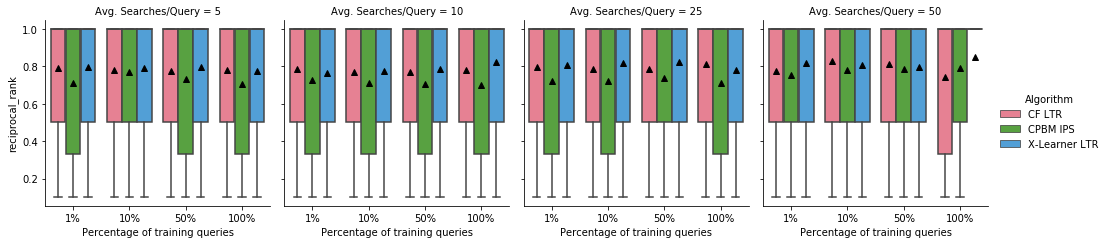

In [42]:
metric = 'reciprocal_rank'
metric_to_plot = ltr_test_results[['algo', 'Avg. Searches/Query', 'Percentage of training queries', metric]].copy()
rename_map = {'cf_binomial': 'CF LTR', 'cpbm': 'CPBM IPS', 'xlearner': 'X-Learner LTR'}
metric_to_plot['algo'] = metric_to_plot['algo'].map(rename_map.get)
metric_to_plot = metric_to_plot.rename(columns={'algo': 'Algorithm'})

g = sns.catplot('Percentage of training queries', metric, 'Algorithm', data=metric_to_plot, col='Avg. Searches/Query', 
                kind='box', palette='husl',
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k', 'marker': '^'}, height=3.5)

T test

In [132]:
cf_ltr_results.head()

,reciprocal_rank,ndcg@1,ndcg@2,ndcg@3,ndcg@4,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@25,algo,avg_clicks,nqueries
0,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,cf_binomial,5,159
1,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,cf_binomial,5,159
2,1.000000,1.0,1.000000,1.000000,0.831872,0.831872,0.944718,0.944718,0.944718,0.944718,cf_binomial,5,159
3,1.000000,1.0,0.613147,0.919721,0.919721,0.919721,0.919721,0.919721,0.919721,0.919721,cf_binomial,5,159
4,1.000000,1.0,1.000000,1.000000,0.831872,0.853932,0.967207,0.967207,0.967207,0.967207,cf_binomial,5,159


In [133]:
cpbm_ltr_results.head()

,reciprocal_rank,ndcg@1,ndcg@2,ndcg@3,ndcg@4,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@25,algo,avg_clicks,nqueries
0,0.200000,0.0,0.000000,0.000000,0.000000,0.386853,0.386853,0.386853,0.386853,0.386853,cpbm,5,159
1,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,cpbm,5,159
2,1.000000,1.0,1.000000,1.000000,0.831872,0.831872,0.944718,0.944718,0.944718,0.944718,cpbm,5,159
3,0.333333,0.0,0.000000,0.306574,0.306574,0.306574,0.500000,0.500000,0.500000,0.500000,cpbm,5,159
4,1.000000,1.0,0.613147,0.469279,0.558508,0.616434,0.863200,0.863200,0.863200,0.863200,cpbm,5,159


In [135]:
xlearner_ltr_results.head()

,reciprocal_rank,ndcg@1,ndcg@2,ndcg@3,ndcg@4,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@25,algo,avg_clicks,nqueries
0,0.166667,0.0,0.0,0.0,0.0,0.0,0.356207,0.356207,0.356207,0.356207,xlearner,5,159
1,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,xlearner,5,159
2,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,xlearner,5,159
3,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,xlearner,5,159
4,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,xlearner,5,159


In [134]:
metrics = ['reciprocal_rank', 'ndcg@10']

In [137]:
metrics = ['ndcg@10']

Causal Forests vs. CPBM

In [138]:
for avg_clicks in [5, 10, 25, 50]:
    for nq in [nqids // i for i in [100, 10, 2, 1]]:
        print(''.join(['=']*20) + f'avg. sample clicks {avg_clicks}; number of queries for estimation {nq}' + ''.join(['=']*20))
        baseline = cpbm_ltr_results[(cpbm_ltr_results['avg_clicks'] == avg_clicks) & (cpbm_ltr_results['nqueries'] == nq)]
        causal_forests = cf_ltr_results[(cf_ltr_results['avg_clicks'] == avg_clicks) & (cf_ltr_results['nqueries'] == nq)]
        for m in metrics:
            baseline_metric = baseline[m].values
            causal_forests_metric = causal_forests[m].values
            print(f'baseline model {m}: {round(baseline_metric.mean(), 4)}; causal forests model {m}: {round(causal_forests_metric.mean(), 4)}')
            print('improvement', ((causal_forests_metric.mean() - baseline_metric.mean()) / baseline_metric.mean()) * 100, '%')
            t, p = stats.ttest_ind(baseline_metric, causal_forests_metric, equal_var=False)
            print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
            print(''.join(['=']*100))

====================avg. sample clicks 5; number of queries for estimation 159====================
baseline model ndcg@10: 0.7461; causal forests model ndcg@10: 0.811
improvement 8.706452181109379 %
t test result: t-statistic -12.581247273169563, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 1596====================
baseline model ndcg@10: 0.7766; causal forests model ndcg@10: 0.815
improvement 4.941344423925533 %
t test result: t-statistic -7.468182959939474, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 7983====================
baseline model ndcg@10: 0.7797; causal forests model ndcg@10: 0.8158
improvement 4.636981097349897 %
t test result: t-statistic -7.059443421957831, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 15966====================
baseline model ndcg@10: 0.7605; causal forests model ndcg@10: 0.8142
improvement 7.057593669360478 %
t test result: t-sta

Causal forests vs X-learner

In [140]:
for avg_clicks in [5, 10, 25, 50]:
    for nq in [nqids // i for i in [100, 10, 2, 1]]:
        print(''.join(['=']*20) + f'avg. sample clicks {avg_clicks}; number of queries for estimation {nq}' + ''.join(['=']*20))
        baseline = cf_ltr_results[(cf_ltr_results['avg_clicks'] == avg_clicks) & (cf_ltr_results['nqueries'] == nq)]
        hte_method = xlearner_ltr_results[(xlearner_ltr_results['avg_clicks'] == avg_clicks) & (xlearner_ltr_results['nqueries'] == nq)]
        for m in metrics:
            baseline_metric = baseline[m].values
            hte_method_metric = hte_method[m].values
            print(f'baseline model {m}: {round(baseline_metric.mean(), 4)}; causal forests model {m}: {round(hte_method_metric.mean(), 4)}')
            print('improvement', ((hte_method_metric.mean() - baseline_metric.mean()) / baseline_metric.mean()) * 100, '%')
            t, p = stats.ttest_ind(baseline_metric, hte_method_metric, equal_var=False)
            print(f't test result: t-statistic {t}, p-value {round(p, 4)}')
            print(''.join(['=']*100))

====================avg. sample clicks 5; number of queries for estimation 159====================
baseline model ndcg@10: 0.811; causal forests model ndcg@10: 0.8343
improvement 2.876282529346664 %
t test result: t-statistic -4.692976319224482, p-value 0.0
====================avg. sample clicks 5; number of queries for estimation 1596====================
baseline model ndcg@10: 0.815; causal forests model ndcg@10: 0.8293
improvement 1.7516352599537846 %
t test result: t-statistic -2.8618848868785336, p-value 0.0042
====================avg. sample clicks 5; number of queries for estimation 7983====================
baseline model ndcg@10: 0.8158; causal forests model ndcg@10: 0.7971
improvement -2.2999115875384093 %
t test result: t-statistic 3.6964588313069986, p-value 0.0002
====================avg. sample clicks 5; number of queries for estimation 15966====================
baseline model ndcg@10: 0.8142; causal forests model ndcg@10: 0.8199
improvement 0.6997929776176133 %
t test res

Cases (P > 0.05): Avg. Query = 5 and Percentage = 100%; Avg. Query = 10 and Percentage = 10%; Avg. Query = 25 and Percentage = 10%; Avg. Query = 25 and Percentage = 50%; Avg. Query = 50 and Percentage = 1%